In [953]:
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
norepo = 'no repository listed'
manualcheckup = 'manual checkup needed'
notgit = 'not git'

In [954]:
q = '''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
where commit_date is not null
and version!=%s;'''
df = pd.DataFrame(sql.execute(q,(manualcheckup)))
df['advisory_id'].nunique()

2497

In [955]:
#not present in Maven central repository
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
where commit_date is not null
and version!=%s
and fc.advisory_id not in
(select advisory_id
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join release_info ri on fr.version = ri.version and ri.package_id=a.package_id);'''
df = pd.DataFrame(sql.execute(q,(manualcheckup)))
df['package_id'].nunique(), df['advisory_id'].nunique()

(75, 145)

In [956]:
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where commit_date is not null
and fr.version!='manual checkup needed'
and ri.publish_date is null;'''
df = pd.DataFrame(sql.execute(q))
df['ri.id'].nunique(), df['package_id'].nunique(), df['advisory_id'].nunique()

(357, 272, 341)

In [957]:
q = '''select advisory_id, count(distinct commit_sha)
from fix_commits
where commit_date is not null
group by advisory_id
having count(distinct commit_sha) > 1'''
df = pd.DataFrame(sql.execute(q))
len(df)

806

In [958]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))

In [959]:
q = '''select * from package_usage pu
join package p on pu.package_id = p.id'''
usage = pd.DataFrame(sql.execute(q))

In [960]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date, cve_date,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date, cve_date
        from advisory a
                left join (select advisory_id, min(C.publish_Date) as cve_date
        from advisoryCVE aC
        join CVE C on aC.cve = C.cve
        group by advisory_id) as ac
            on ac.advisory_id=a.id
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;
'''
df = pd.DataFrame(sql.execute(q))
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31 20:29:00,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23 00:15:00,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20 09:15:00,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19 23:15:00,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19 09:15:00,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-JS-GITLOG-1070779,3927,npm,Command Injection,H,2021-02-09,2021-02-09,2021-02-08 17:15:00,2020-12-17 11:48:28,2020-12-17 11:56:13,2021-01-05 21:20:58,4.0.4,package3927version4.0.4,SNYK-JS-GITLOG-107077939274.0.4
2785,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0
2786,SNYK-JS-PROGFAYSCRAPBOXPARSER-1076803,3934,npm,Regular Expression Denial of Service (ReDoS),H,2021-02-19,2021-02-19,2021-02-19 05:15:00,2021-02-07 09:37:40,2021-02-18 15:44:02,2021-02-18 16:06:23,6.0.3,package3934version6.0.3,SNYK-JS-PROGFAYSCRAPBOXPARSER-107680339346.0.3
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23


In [961]:
len(df)
df['cve_date'] = df['cve_date'].dt.date
t1 = df[~df['cve_date'].isna()].copy()
t1['advisory_date'] = t1[['cve_date', 'publish_date']].min(axis=1)
t2 = df[df['cve_date'].isna()].copy()
t2['advisory_date'] = t2['publish_date']
df = pd.concat([t1, t2], ignore_index=True, sort=False)
len(df)

2789

In [962]:
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

df['fix_commit_date'] = df.apply(get_fix_commit_date, axis=1)
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,advisory_date,fix_commit_date
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,3909,Go,Information Exposure,M,2021-01-31,2021-01-31,NaT,2021-01-13 16:44:30,2021-01-29 19:46:46,2021-01-28 17:07:32,0.12.10,package3909version0.12.10,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,2021-01-31,2021-01-13 16:44:30
2785,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,3909,Go,Information Exposure,M,2021-01-31,2021-01-31,NaT,2021-01-13 16:44:30,2021-01-29 19:46:46,2021-01-28 16:17:14,1.0.3,package3909version1.0.3,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,2021-01-31,2021-01-13 16:44:30
2786,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56


In [963]:
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['advisory_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['advisory_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,advisory_date,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06,0.0,1,2,2
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05,12.0,-41,29,41
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54,173.0,-190,16,189
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50,6.0,-299,291,297
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50,21.0,-37,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,3909,Go,Information Exposure,M,2021-01-31,2021-01-31,NaT,2021-01-13 16:44:30,2021-01-29 19:46:46,2021-01-28 17:07:32,0.12.10,package3909version0.12.10,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,2021-01-31,2021-01-13 16:44:30,15.0,-18,3,18
2785,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,3909,Go,Information Exposure,M,2021-01-31,2021-01-31,NaT,2021-01-13 16:44:30,2021-01-29 19:46:46,2021-01-28 16:17:14,1.0.3,package3909version1.0.3,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,2021-01-31,2021-01-13 16:44:30,15.0,-18,3,18
2786,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30,34.0,0,-14,20
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56,0.0,0,0,0


In [964]:
df['advisory_id'].nunique(), df['fixing_release'].nunique(),  df['total_release'].nunique()

(2068, 2355, 2789)

In [965]:
total = len(df)
d2f = df[df['disclose_to_fix_delay'] > 0]
before = len(d2f)
d2f['disclose_to_fix_delay'].describe(), before/total


(count     781.000000
 mean       79.177977
 std       193.344665
 min         1.000000
 25%         2.000000
 50%         8.000000
 75%        42.000000
 max      1849.000000
 Name: disclose_to_fix_delay, dtype: float64,
 0.28002868411617066)

In [966]:
df['release_to_publish_delay'].describe()

count    2789.000000
mean      111.258516
std       389.495768
min     -2243.000000
25%         0.000000
50%         7.000000
75%        58.000000
max      4918.000000
Name: release_to_publish_delay, dtype: float64

In [967]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong = wrong.sample(frac=1).reset_index(drop=True)
wrong.to_csv('delaylessthanzero.csv', index=False)
len(wrong)

149

In [968]:
temp = df[df['fix_to_publish_delay']<0]
temp = pd.merge(temp, ifcve)

In [969]:
q = '''select advisory_id, cwe, package_id, ecosystem, type, severity, disclose_date, publish_date,
earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
concat(advisory_id, package_id, version) as total_release
from
(select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, ac.cwe, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
    join advisoryCWE aC on a.id = aC.advisory_id
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id;'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe

,cwe
ecosystem,
Composer,40
Go,46
Maven,83
NuGet,10
RubyGems,41
npm,72
pip,68


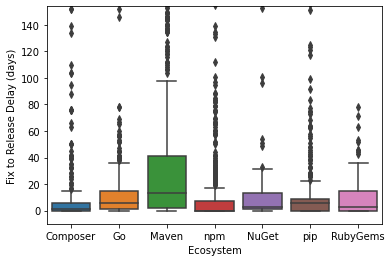

In [970]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = df, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim =(-10,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight')

<ipython-input-971-3cab2230524b>:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(ylim =(0,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days, log-scaled)')


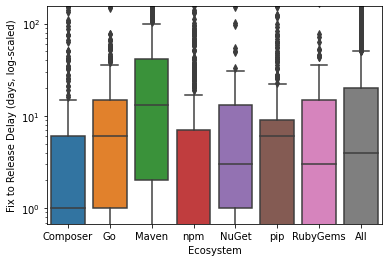

In [971]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set_yscale("log")
ax.set(ylim =(0,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days, log-scaled)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight', dpi=960)

In [972]:
usage = pd.merge(df, usage, on=['package_id', 'ecosystem'])
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ecosystems = ['Composer','Go','Maven','npm','NuGet','pip','RubyGems']
l=[]
newl = []
for ecosystem in ecosystems:
    temp = usage[usage['ecosystem'] ==  ecosystem ]
    a = spearmanr(temp['fix_to_release_delay'], temp['dependent'])
    b = spearmanr(temp['fix_to_release_delay'], temp['dependent_repos'])
    l.append([ecosystem, a ,b])
    newl.append([ecosystem, round(a[0],2), round(b[0],2)])

l.append(['All', spearmanr(usage['fix_to_release_delay'], usage['dependent']), spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])])
newl.append(['All', round(spearmanr(usage['fix_to_release_delay'], usage['dependent'])[0],2), round(spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])[0],2)])
l

[['Composer',
  SpearmanrResult(correlation=-0.19274162798335198, pvalue=0.0008758277679639522),
  SpearmanrResult(correlation=-0.19313317663568705, pvalue=0.0008544152831027935)],
 ['Go',
  SpearmanrResult(correlation=-0.08512691206101582, pvalue=0.4527855063469092),
  SpearmanrResult(correlation=-0.03645625433061777, pvalue=0.7481729053274095)],
 ['Maven',
  SpearmanrResult(correlation=-0.23075387038431322, pvalue=3.342025940707579e-11),
  SpearmanrResult(correlation=-0.21477566588533084, pvalue=7.271081824157687e-10)],
 ['npm',
  SpearmanrResult(correlation=0.2654663405975448, pvalue=8.759755936018743e-12),
  SpearmanrResult(correlation=0.23257873707308407, pvalue=2.6140324297388564e-09)],
 ['NuGet',
  SpearmanrResult(correlation=0.2524220463037674, pvalue=0.028900944638176464),
  SpearmanrResult(correlation=0.15641045803445533, pvalue=0.1802233803982572)],
 ['pip',
  SpearmanrResult(correlation=0.050948907077986015, pvalue=0.2862582842167252),
  SpearmanrResult(correlation=0.006283

In [973]:
newl =  pd.DataFrame(newl, columns=['Ecosytem', 'Dependent Packages', 'Dependent Repositories'])
print(tabulate(newl, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrr}
\hline
 Ecosytem   &   Dependent Packages &   Dependent Repositories \\
\hline
 Composer   &                -0.19 &                    -0.19 \\
 Go         &                -0.09 &                    -0.04 \\
 Maven      &                -0.23 &                    -0.21 \\
 npm        &                 0.27 &                     0.23 \\
 NuGet      &                 0.25 &                     0.16 \\
 pip        &                 0.05 &                     0.01 \\
 RubyGems   &                -0.11 &                    -0.16 \\
 All        &                -0.05 &                    -0.09 \\
\hline
\end{tabular}


In [974]:
len(df[df['fix_to_release_delay']>= 500])
df['fix_to_release_delay'].describe()

count    2640.000000
mean       30.954924
std       115.271483
min         0.000000
25%         0.000000
50%         4.000000
75%        20.000000
max      2363.000000
Name: fix_to_release_delay, dtype: float64

In [975]:
npm =df[df['ecosystem']=='npm']
len(npm), len(npm[npm['fix_to_release_delay']==0])

(640, 322)

In [976]:
maven = df[df['ecosystem']=='Maven']
maven['fix_to_release_delay'].describe(), len(maven[maven['fix_to_release_delay']==0])

(count     807.000000
 mean       51.630731
 std       162.032630
 min         0.000000
 25%         2.000000
 50%        13.000000
 75%        41.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 121)

In [977]:
pbf = df[df['fix_to_publish_delay'] < 0]
pbf['release_to_publish_delay'].describe()

count     253.000000
mean     -117.833992
std       198.412939
min     -1196.000000
25%      -145.000000
50%       -32.000000
75%        -9.000000
max        -1.000000
Name: release_to_publish_delay, dtype: float64

In [978]:
pbr = df[(df['release_to_publish_delay'] < 0) & (df['fix_to_publish_delay'] >= 0)]
pbr['release_to_publish_delay'].describe()

count     296.000000
mean      -83.722973
std       229.225751
min     -2243.000000
25%       -63.250000
50%       -17.500000
75%        -5.750000
max        -1.000000
Name: release_to_publish_delay, dtype: float64

In [979]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = len(pub_before_release)

pub_before_release = str(pub_before_release) + ' (' +  str(round(pub_before_release/df['advisory_id'].nunique()*100,1)) +'%)'
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = len(pub_before_fix)
pub_before_fix = str(pub_before_fix) + ' (' + str(round(pub_before_fix/df['advisory_id'].nunique()*100,1)) +'%)'
t = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['fixing_release'].nunique(), 
total_cwes,
df['fix_to_release_delay'].median(),
df['total_release'].nunique(), pub_before_fix, pub_before_release ]
t[3] = str(t[3]) + ' (' + str(t[6]) +')'
del t[6]
t

['Total', 2001, 1342, '2240 (2640)', 143, 4.0, '202 (10.1%)', '449 (22.4%)']

In [980]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')['fixing_release'].nunique()
total_rel = df.groupby('ecosystem')['total_release'].nunique()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()

In [981]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_release = pub_before_release.rename(columns={'advisory_id':'pub_before_release'})
pub_before_release

,pub_before_release
ecosystem,
Composer,27
Go,48
Maven,153
NuGet,14
RubyGems,15
npm,113
pip,79


In [982]:
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_fix = pub_before_fix.rename(columns={'advisory_id':'pub_before_fix'})
pub_before_fix

,pub_before_fix
ecosystem,
Composer,13
Go,21
Maven,40
NuGet,8
RubyGems,9
npm,72
pip,39


In [983]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel,cwe, fixrel, pub_before_fix,pub_before_release, total_rel])
final = final.reset_index()
final['fixing_release'] = final['fixing_release'].map(str) +  ' (' + final['total_release'].map(str) +')'
final

,ecosystem,advisory_id,package_id,fixing_release,cwe,fix_to_release_delay,pub_before_fix,pub_before_release,total_release
0,Composer,183,93,204 (295),40,1.0,13,27,295
1,Go,184,150,224 (242),46,6.0,21,48,242
2,Maven,574,385,745 (807),83,13.0,40,153,807
3,NuGet,70,22,52 (75),10,3.0,8,14,75
4,RubyGems,113,80,121 (139),41,3.0,9,15,139
5,npm,553,412,586 (640),72,0.0,72,113,640
6,pip,324,200,308 (442),68,6.0,39,79,442


In [984]:
q = 'select * from advisoryCWE'
cwe = pd.DataFrame(sql.execute(q))
df = df.merge(cwe, on='advisory_id')
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,...,version,fixing_release,total_release,advisory_date,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay,cwe
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,...,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06,0.0,1,2,2,CWE-79
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,...,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05,12.0,-41,29,41,CWE-200
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,...,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54,173.0,-190,16,189,CWE-79
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,...,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50,6.0,-299,291,297,CWE-200
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,...,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50,21.0,-37,16,37,CWE-352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,3909,Go,Information Exposure,M,2021-01-31,2021-01-31,NaT,2021-01-13 16:44:30,2021-01-29 19:46:46,...,0.12.10,package3909version0.12.10,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,2021-01-31,2021-01-13 16:44:30,15.0,-18,3,18,CWE-200
2726,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,3909,Go,Information Exposure,M,2021-01-31,2021-01-31,NaT,2021-01-13 16:44:30,2021-01-29 19:46:46,...,1.0.3,package3909version1.0.3,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,2021-01-31,2021-01-13 16:44:30,15.0,-18,3,18,CWE-200
2727,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,...,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30,34.0,0,-14,20,CWE-208
2728,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,...,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56,0.0,0,0,0,CWE-288


In [985]:

final.columns = ['ecosystem','advisory','package','releases', 'cwe', 'fix_to_release','publish_before_fix', 'publish_before_release', 'total_release']
final['temp'] = final['publish_before_release'] 
final['publish_before_release'] =  round(final['publish_before_release'] / final['advisory'] * 100, 1)
final['publish_before_release'] = final['temp'].map(str) + ' (' + final['publish_before_release'].map(str) + '%)'
final['temp'] = final['publish_before_fix'] 
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['advisory'] * 100, 1)
final['publish_before_fix'] = final['temp'].map(str) + ' (' + final['publish_before_fix'].map(str) + '%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp','total_release'], axis=1)
final.loc[len(final)]  = t
final

,ecosystem,advisory,package,releases,cwe,fix_to_release,publish_before_fix,publish_before_release
0,Composer,183,93,204 (295),40,1.0,13 (7.1%),27 (14.8%)
1,Go,184,150,224 (242),46,6.0,21 (11.4%),48 (26.1%)
2,Maven,574,385,745 (807),83,13.0,40 (7.0%),153 (26.7%)
5,npm,553,412,586 (640),72,0.0,72 (13.0%),113 (20.4%)
3,NuGet,70,22,52 (75),10,3.0,8 (11.4%),14 (20.0%)
6,pip,324,200,308 (442),68,6.0,39 (12.0%),79 (24.4%)
4,RubyGems,113,80,121 (139),41,3.0,9 (8.0%),15 (13.3%)
7,Total,2001,1342,2240 (2640),143,4.0,202 (10.1%),449 (22.4%)


In [986]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrlrrll}
\hline
 ecosystem   &   advisory &   package & releases    &   cwe &   fix\_to\_release & publish\_before\_fix   & publish\_before\_release   \\
\hline
 Composer    &        183 &        93 & 204 (295)   &    40 &                1 & 13 (7.1\%)            & 27 (14.8\%)               \\
 Go          &        184 &       150 & 224 (242)   &    46 &                6 & 21 (11.4\%)           & 48 (26.1\%)               \\
 Maven       &        574 &       385 & 745 (807)   &    83 &               13 & 40 (7.0\%)            & 153 (26.7\%)              \\
 npm         &        553 &       412 & 586 (640)   &    72 &                0 & 72 (13.0\%)           & 113 (20.4\%)              \\
 NuGet       &         70 &        22 & 52 (75)     &    10 &                3 & 8 (11.4\%)            & 14 (20.0\%)               \\
 pip         &        324 &       200 & 308 (442)   &    68 &                6 & 39 (12.0\%)           & 79 (24.4\%)               \\
 RubyGems    &    

In [987]:
shuffled = df[df['fix_to_release_delay'] > 20]
shuffled = shuffled.sample(frac=1).reset_index(drop=True)
shuffled.to_csv('rq1_fourth_quartile.csv')
len(shuffled)

680

In [988]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [989]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    1201.000000
 mean       27.214821
 std        90.554342
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1380.000000
 mean       33.289130
 std       116.745826
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     149.00000
 mean       46.61745
 std       233.17412
 min         0.00000
 25%         0.00000
 50%         3.00000
 75%        14.00000
 max      2363.00000
 Name: fix_to_release_delay, dtype: float64)

In [990]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay']), high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(MannwhitneyuResult(statistic=780357.5, pvalue=0.004585319606954429),
 MannwhitneyuResult(statistic=87231.5, pvalue=0.3051806077068462),
 MannwhitneyuResult(statistic=98661.5, pvalue=0.20540886781767842),
 count    1201.000000
 mean       27.214821
 std        90.554342
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1380.000000
 mean       33.289130
 std       116.745826
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     149.00000
 mean       46.61745
 std       233.17412
 min         0.00000
 25%         0.00000
 50%         3.00000
 75%        14.00000
 max      2363.00000
 Name: fix_to_release_delay, dtype: float64)

In [991]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub)
group by advisory_id, package_id, ecosystem;
'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe(), len(multiple_rel[multiple_rel['range']==0])

(count     392.000000
 mean       61.946429
 std       227.415502
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         8.000000
 max      1718.000000
 Name: range, dtype: float64,
 203)

In [992]:
multiple_rel = multiple_rel[multiple_rel['range'] > 0 ]
multiple_rel['range'].describe()

count     189.000000
mean      128.481481
std       314.591877
min         1.000000
25%         3.000000
50%         8.000000
75%        55.000000
max      1718.000000
Name: range, dtype: float64

In [993]:
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

2730 6956


2730

In [994]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

2041 689


In [995]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    2041.000000
 mean       26.777560
 std       108.444445
 min         0.000000
 25%         0.000000
 50%         4.000000
 75%        18.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 count     689.000000
 mean       44.872279
 std       135.238220
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        26.000000
 max      1341.000000
 Name: fix_to_release_delay, dtype: float64)

In [996]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=5346.0, pvalue=0.043378333849292613)

In [997]:
q = '''select a.id as advisory_id, a.severity, p.id as package_id, p.ecosystem, a.publish_date as snyk_date, ac.cve_date, min(ri.publish_date) as release_date
from advisory a
    left join (select advisory_id, min(C.publish_Date) as cve_date
from advisoryCVE aC
join CVE C on aC.cve = C.cve
group by advisory_id) as ac
    on ac.advisory_id=a.id
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and fr.version=ri.version
join advisoryCWE acwe on a.id= acwe.advisory_id
where ri.publish_date is not null
group by a.id;'''
df = pd.DataFrame(sql.execute(q))
len(df)

3655

In [998]:
df['cve_date'] = df['cve_date'].dt.date
t1 = df[~df['cve_date'].isna()].copy()
t1['advisory_date'] = t1[['cve_date', 'snyk_date']].min(axis=1)
t2 = df[df['cve_date'].isna()].copy()
t2['advisory_date'] = t2['snyk_date']
df = pd.concat([t1, t2], ignore_index=True, sort=False)
len(df)

3655

In [999]:
df['rtp_delay'] = (df['advisory_date'] - df['release_date'].dt.date).dt.days

In [1000]:
'''The start of analysis of RQ4'''

'The start of analysis of RQ4'

In [1001]:
df['advisory_id'].nunique()

3655

In [1002]:
total_adv = df.groupby('ecosystem')[['advisory_id']].nunique()
total_c = df['advisory_id'].nunique()
total_adv

,advisory_id
ecosystem,
Composer,751
Go,211
Maven,937
NuGet,241
RubyGems,211
npm,735
pip,569


In [1003]:
df = df[df['rtp_delay'] >= 0]
len(df)

2915

In [1004]:
usage = pd.merge(df, usage, on=['package_id', 'ecosystem'])
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ecosystems = ['Composer','Go','Maven','npm','NuGet','pip','RubyGems']
l=[]
newl = []
for ecosystem in ecosystems:
    temp = usage[usage['ecosystem'] ==  ecosystem ]
    a = spearmanr(temp['rtp_delay'], temp['dependent'])
    b = spearmanr(temp['rtp_delay'], temp['dependent_repos'])
    l.append([ecosystem, a ,b])
    newl.append([ecosystem, round(a[0],2), round(b[0],2)])

l.append(['All', spearmanr(usage['fix_to_release_delay'], usage['dependent']), spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])])
newl.append(['All', round(spearmanr(usage['fix_to_release_delay'], usage['dependent'])[0],2), round(spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])[0],2)])
l

[['Composer',
  SpearmanrResult(correlation=0.27767927385681285, pvalue=2.0698257918378516e-68),
  SpearmanrResult(correlation=0.29062409950575424, pvalue=4.769691345300373e-75)],
 ['Go',
  SpearmanrResult(correlation=-0.12495014211694579, pvalue=0.17574581127463196),
  SpearmanrResult(correlation=-0.1040945670966704, pvalue=0.25990512089841455)],
 ['Maven',
  SpearmanrResult(correlation=0.10798795289985176, pvalue=7.028709313672804e-12),
  SpearmanrResult(correlation=-0.004713309772004272, pvalue=0.7653871278166565)],
 ['npm',
  SpearmanrResult(correlation=0.049626421424657535, pvalue=0.009206946006718073),
  SpearmanrResult(correlation=0.06084732364171452, pvalue=0.0014026245826688375)],
 ['NuGet',
  SpearmanrResult(correlation=0.2473812538186645, pvalue=1.3742162279333902e-38),
  SpearmanrResult(correlation=0.2246703665112742, pvalue=5.889472927249429e-32)],
 ['pip',
  SpearmanrResult(correlation=-0.2856971868151739, pvalue=1.8356111420663645e-62),
  SpearmanrResult(correlation=-0.2

In [1005]:
df

,advisory_id,severity,package_id,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay
0,npm:adm-zip:20180415,H,2289,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19
1,npm:aerospike:20161101,H,2956,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26
2,npm:angular-http-server:20180302,H,2421,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40
3,npm:angular-jwt:20180605,M,2185,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20
4,npm:anywhere:20180226,H,2408,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16
...,...,...,...,...,...,...,...,...,...
3646,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,M,3909,Go,2021-01-31,NaT,2021-01-28 16:17:14,2021-01-31,3
3650,SNYK-JAVA-ORGWEBJARSNPM-480133,H,3382,Maven,2017-01-18,NaT,2015-10-24 02:13:00,2017-01-18,452
3651,SNYK-JAVA-ORGWEBJARSNPM-1014643,M,187,Maven,2020-10-01,NaT,2020-09-22 23:57:00,2020-10-01,9
3652,SNYK-JAVA-ORGAPACHEFELIX-174782,M,1862,Maven,2019-05-26,NaT,2019-05-21 16:59:00,2019-05-26,5


In [1006]:
df['rtp_delay'].describe()

count    2915.000000
mean      172.657290
std       427.305137
min         0.000000
25%         2.000000
50%        17.000000
75%       109.000000
max      4918.000000
Name: rtp_delay, dtype: float64

In [1007]:
h = df[df['severity'] == 'H']
h['rtp_delay'].describe()

count    1284.000000
mean      146.155763
std       419.984009
min         0.000000
25%         1.000000
50%         9.000000
75%        68.250000
max      4918.000000
Name: rtp_delay, dtype: float64

In [1008]:
m = df[df['severity'] == 'M']
m['rtp_delay'].describe()

count    1499.000000
mean      193.953302
std       427.212265
min         0.000000
25%         3.000000
50%        22.000000
75%       148.000000
max      3603.000000
Name: rtp_delay, dtype: float64

In [1009]:
l = df[df['severity'] == 'L']
l['rtp_delay'].describe()

count     132.000000
mean      188.606061
std       484.466398
min         0.000000
25%         1.000000
50%        12.000000
75%       110.250000
max      4301.000000
Name: rtp_delay, dtype: float64

In [1010]:
mannwhitneyu(h['rtp_delay'], m['rtp_delay'])

MannwhitneyuResult(statistic=823499.0, pvalue=2.3054427482404182e-11)

In [1011]:
mannwhitneyu(h['rtp_delay'], l['rtp_delay'])

MannwhitneyuResult(statistic=83559.0, pvalue=0.39528658515948334)

In [1012]:
random = df.sample(frac=1)
random.to_csv('rtpdelay.csv')

In [1013]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
delay = df.groupby('ecosystem')[['rtp_delay']].median()

In [1014]:
final = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[total_adv, adv, delay])
final = final.reset_index()
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp'], axis=1)
All = ['All', total_c,  df['advisory_id'].nunique(), df['rtp_delay'].median()]
final.loc[len(final)]=All
final

,ecosystem,advisory_id_x,advisory_id_y,rtp_delay
0,Composer,751,675,8.0
1,Go,211,160,11.5
2,Maven,937,715,41.0
5,npm,735,592,17.5
3,NuGet,241,208,1.0
6,pip,569,424,11.0
4,RubyGems,211,141,77.0
7,All,3655,2915,17.0


In [1015]:
final = final.rename(columns={'advisory_id_x':'a', 'advisory_id_y':'ar', })

In [1016]:

final['p'] = round(final['ar']/final['a']*100,1)
final['ar'] = final['ar'].map(str) + ' (' + final['p'].map(str) + '%)'
final = final.drop('p', axis=1)

In [1017]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrlr}
\hline
 ecosystem   &    a & ar           &   rtp\_delay \\
\hline
 Composer    &  751 & 675 (89.9\%)  &         8   \\
 Go          &  211 & 160 (75.8\%)  &        11.5 \\
 Maven       &  937 & 715 (76.3\%)  &        41   \\
 npm         &  735 & 592 (80.5\%)  &        17.5 \\
 NuGet       &  241 & 208 (86.3\%)  &         1   \\
 pip         &  569 & 424 (74.5\%)  &        11   \\
 RubyGems    &  211 & 141 (66.8\%)  &        77   \\
 All         & 3655 & 2915 (79.8\%) &        17   \\
\hline
\end{tabular}


In [1018]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)

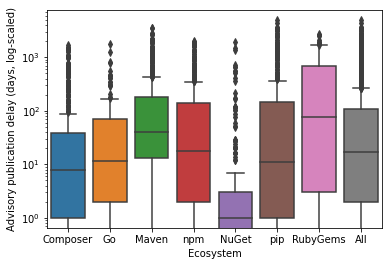

In [1019]:
ax = sns.boxplot(y='rtp_delay', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set( xlabel='Ecosystem', ylabel='Advisory publication delay (days, log-scaled)')
ax.set_yscale("log")
plt.savefig('rtp_delay.pdf',bbox_inches='tight', dpi = 960)

In [1020]:
df

,advisory_id,severity,package_id,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay
0,npm:adm-zip:20180415,H,2289,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19
1,npm:aerospike:20161101,H,2956,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26
2,npm:angular-http-server:20180302,H,2421,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40
3,npm:angular-jwt:20180605,M,2185,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20
4,npm:anywhere:20180226,H,2408,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16
...,...,...,...,...,...,...,...,...,...
3646,SNYK-GOLANG-GITHUBCOMHASHICORPNOMADDRIVERSSHAR...,M,3909,Go,2021-01-31,NaT,2021-01-28 16:17:14,2021-01-31,3
3650,SNYK-JAVA-ORGWEBJARSNPM-480133,H,3382,Maven,2017-01-18,NaT,2015-10-24 02:13:00,2017-01-18,452
3651,SNYK-JAVA-ORGWEBJARSNPM-1014643,M,187,Maven,2020-10-01,NaT,2020-09-22 23:57:00,2020-10-01,9
3652,SNYK-JAVA-ORGAPACHEFELIX-174782,M,1862,Maven,2019-05-26,NaT,2019-05-21 16:59:00,2019-05-26,5


In [1021]:
total = df.groupby('ecosystem')[['advisory_id']].nunique()
total

,advisory_id
ecosystem,
Composer,675
Go,160
Maven,715
NuGet,208
RubyGems,141
npm,592
pip,424


In [1022]:
cve = df[~df['cve_date'].isna()]
cve['rtp_delay'].median(), len(cve)

(13.0, 2116)

In [1023]:
noncve = df[df['cve_date'].isna()]
noncve['rtp_delay'].median()

26.0

In [1024]:
mannwhitneyu(cve['rtp_delay'], noncve['rtp_delay'])

MannwhitneyuResult(statistic=706054.0, pvalue=2.892590387116665e-12)

In [1025]:
len(cve), len(noncve)

(2116, 799)

In [1026]:
cve_count = cve.groupby('ecosystem')[['advisory_id']].nunique()
cve_delay = cve.groupby('ecosystem')[['rtp_delay']].median()
noncve_count = noncve.groupby('ecosystem')[['advisory_id']].nunique()
noncve_delay = noncve.groupby('ecosystem')[['rtp_delay']].median()
cvenoncve = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[ cve_count, cve_delay, noncve_count, noncve_delay])
cvenoncve = cvenoncve.reset_index()
cvenoncve

,ecosystem,advisory_id_x,rtp_delay_x,advisory_id_y,rtp_delay_y
0,Composer,449,9.0,226,4.0
1,Go,130,11.5,30,12.5
2,Maven,620,35.0,95,99.0
3,NuGet,179,1.0,29,3.0
4,RubyGems,99,8.0,42,916.5
5,npm,341,9.0,251,41.0
6,pip,298,3.0,126,155.0


In [1027]:
print(tabulate(cvenoncve, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrr}
\hline
 ecosystem   &   advisory\_id\_x &   rtp\_delay\_x &   advisory\_id\_y &   rtp\_delay\_y \\
\hline
 Composer    &             449 &           9   &             226 &           4   \\
 Go          &             130 &          11.5 &              30 &          12.5 \\
 Maven       &             620 &          35   &              95 &          99   \\
 NuGet       &             179 &           1   &              29 &           3   \\
 RubyGems    &              99 &           8   &              42 &         916.5 \\
 npm         &             341 &           9   &             251 &          41   \\
 pip         &             298 &           3   &             126 &         155   \\
\hline
\end{tabular}


In [1028]:
h = df[df['severity']== 'H']
m = df[df['severity']== 'M']
l = df[df['severity']== 'L']
h['rtp_delay'].median(), m['rtp_delay'].median(), len(l), l['rtp_delay'].median()

(9.0, 22.0, 132, 12.0)

In [1029]:
mannwhitneyu(h['rtp_delay'], l['rtp_delay'])

MannwhitneyuResult(statistic=83559.0, pvalue=0.39528658515948334)

In [1030]:
df['release_year'] = df['release_date'].dt.year
df.groupby('release_year')[['rtp_delay']].median()

,rtp_delay
release_year,
2005,855.0
2006,7.0
2008,3493.0
2009,539.5
2010,942.0
2011,513.0
2012,256.0
2013,148.0
2014,103.0


In [1031]:
usage.groupby('ecosystem')[['dependent_repos']].median()

,dependent_repos
ecosystem,
Composer,2679
Go,50
Maven,3808
NuGet,39
RubyGems,9593
npm,23496
pip,11262


In [1032]:
cve['cvedelay'] = (cve['cve_date'] - cve['snyk_date']).dt.days
cve['cvedelay'].describe()
cve

<ipython-input-1032-b0388dd92ad4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cve['cvedelay'] = (cve['cve_date'] - cve['snyk_date']).dt.days


,advisory_id,severity,package_id,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay,cvedelay
0,npm:adm-zip:20180415,H,2289,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19,55
1,npm:aerospike:20161101,H,2956,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26,539
2,npm:angular-http-server:20180302,H,2421,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40,91
3,npm:angular-jwt:20180605,M,2185,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20,-58
4,npm:anywhere:20180226,H,2408,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16,93
...,...,...,...,...,...,...,...,...,...,...
2647,SNYK-JAVA-ORGOPENCMS-460332,H,1463,Maven,2019-08-27,2019-08-27,2019-05-22 13:14:00,2019-08-27,97,0
2649,SNYK-JAVA-ORGJBOSSWELD-30125,M,2911,Maven,2016-12-25,2015-02-13,2014-12-04 20:22:00,2015-02-13,71,-681
2654,SNYK-JAVA-ORGWSO2CARBONGOVERNANCE-608305,H,512,Maven,2020-08-23,2020-08-21,2020-05-02 13:12:00,2020-08-21,111,-2
2655,SNYK-JAVA-ORGWSO2CARBONGOVERNANCE-608304,H,515,Maven,2020-08-23,2020-08-21,2020-05-02 12:48:00,2020-08-21,111,-2
